In [84]:
import numpy as np
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, GlobalAveragePooling2D, Input, AveragePooling2D, BatchNormalization, UpSampling2D, RandomFlip, RandomRotation
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.python.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from tensorflow.python.ops.gen_dataset_ops import dataset_to_graph_eager_fallback


In [85]:
def load_dataset(npz_file_path):
  data = np.load(npz_file_path)
  # train_dataset = np.column_stack((data['train_images'], data['train_labels']))
  # test_dataset = np.column_stack((data['test_images'], data['test_labels']))
  train_X = data['train_images']
  train_Y = data['train_labels']
  test_X = data['test_images']
  test_Y = data['test_labels']
  val_X = data['val_images']
  val_Y = data['val_labels']
  lst = data.files

  return train_X, train_Y, test_X, test_Y, val_X, val_Y


In [119]:
def check_train_class_balance(train_Y) -> (bool, dict):

  unique, counts = np.unique(train_Y, return_counts=True)
  label_dict = dict(zip(unique, counts))
  isTrue =  True if label_dict[0] == label_dict[1] else False
  return isTrue, label_dict


In [87]:
def plot_ground_truth_images(train_X, train_Y):
  # Convert the output labels to one-hot encoded format#
  y_breast = to_categorical(train_Y)

  # Create a dictionary mapping class indices to class labels
  class_labels_breast = {0: 'Malignant',1: 'Normal'}

  # Randomly select 10 images from the dataset
  indices_breast = np.random.choice(train_X.shape[0], size=15, replace=False)

  # Plot the images and corresponding class labels
  fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 5))
  for i, ax in enumerate(axes.flat):
    ax.imshow(train_X[indices_breast[i]], cmap='gray')
    ax.set_title(class_labels_breast[np.argmax(y_breast[indices_breast[i]])])
    ax.axis('off')
  plt.tight_layout()
  plt.show()


True

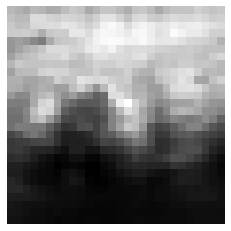

In [88]:
import matplotlib.pyplot as plt
import cv2 as cv2
from PIL import Image
indx = 10
plt.imshow(test_X[indx], cmap='gray')

plt.axis('off')
# plt.imsave('test_18.jpg',test_X[indx], cmap='gray')
# plt.show()
im = Image.fromarray(np.uint8(test_X[indx]))
cv2.imwrite('test_10.png', test_X[indx])

In [131]:
def oversample_train_data_class(train_X,train_Y)-> (bool, np.ndarray, np.ndarray, dict):
  # Preprocess train X data for oversampling, i.e. flattening shape from (546,28,28) to (546,784)
  X = train_X.reshape(len(train_X),-1)

  # Use RandomOverSampler from imblearn for oversampling minority class, i.e. 0 (Malignant) in this case
  ros = RandomOverSampler(random_state=0)
  X_resampled, y_resampled = ros.fit_resample(X, train_Y)

  # Reshape train data back to (798,28,28)
  X_resampled=X_resampled.reshape(798,28,28)
  X_resampled = np.expand_dims(X_resampled, axis=-1)
  unique, counts = np.unique(y_resampled, return_counts=True)
  label_dict = dict(zip(unique, counts))

  # Evaluate the oversampled data and check for imbalance again
  isTrue =  True if label_dict[0] == label_dict[1] else False
  return isTrue, X_resampled, y_resampled, label_dict

In [132]:
def augment_train_data(train_X, train_Y, batch_size=32):
  datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
  )

  datagen.fit(train_X)
  augmented_data = datagen.flow(train_X, train_Y, batch_size=batch_size)
  return augmented_data

In [133]:

def create_model_backbone()->keras.Model:
  model = Sequential()
  model.add(Conv2D(16,kernel_size=(3,3), padding='valid', activation='relu', input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='valid'))
  # 

  model.add(Conv2D(32,kernel_size=(3,3), padding='valid', activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(BatchNormalization())

  model.add(Conv2D(32,kernel_size=(3,3), padding='valid', activation='relu'))

  model.add(MaxPooling2D(pool_size=(2,2)))
  # model.add(Conv2D(64,kernel_size=(3,3), padding='valid', activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='valid'))


  model.add(Conv2D(128,kernel_size=(3,3), padding='same', activation='relu', ))
  model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))
  # model.add(UpSampling2D(size=(2, 2)))

  # model.add(Conv2D(256,kernel_size=(3,3), padding='same', activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=2, padding='same'))

  model.add(Flatten())

  # model.add(Dense(256, activation='relu'))
  # model.add(Dropout(0.1))
  # model.add(Dropout(0.5))
  # model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l1(0.05)))
  return model

In [134]:
def compile_model(model: keras.Model) -> keras.Model:
  # Create Adam optimizer with learning rate set to 0.0001
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)

  # Create Binary Cross entropy for loss function
  loss = tf.keras.losses.BinaryCrossentropy()

  # Compile and return model
  model.compile(optimizer=optimizer,loss=loss, metrics=['accuracy'])
  return model

In [135]:
def train_model(train_data, model: keras.Model, validation_X:np.ndarray,validation_Y:np.ndarray, callbacks = [], epochs=160, verbose=1, steps_per_epoch=23):
  
  # Fit model for training
  history = model.fit(train_data, validation_data=(val_X, val_Y), epochs=epochs, verbose=verbose, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

In [136]:
def plot_model_accuracy_graph():
  training_loss = history.history['loss']
  test_loss = history.history['val_loss']

  epoch_count = range(1, len(training_loss) + 1)

  plt.plot(epoch_count, training_loss, "r--")
  plt.plot(epoch_count, test_loss, "b--")
  plt.legend(["Training Loss", "Test Loss"])
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.yticks([0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00])
  plt.show()

  training_accuracy = history.history["accuracy"]
  test_accuracy = history.history["val_accuracy"]

  plt.plot(epoch_count, training_accuracy, "r--")
  plt.plot(epoch_count, test_accuracy, "b--")
  plt.legend(["Training Accuracy", "Test Accuracy"])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy Score")
  plt.yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
  plt.show()

In [137]:
def predict_class_of_image(model: keras.Model, indx: int):
  test = test_X[ind].reshape(-1,28,28,1)
  print(model.predict(test))
  print(test_Y[ind])

In [138]:
# Train, Val, Test - loading of data
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_dataset('/content/breastmnist.npz')

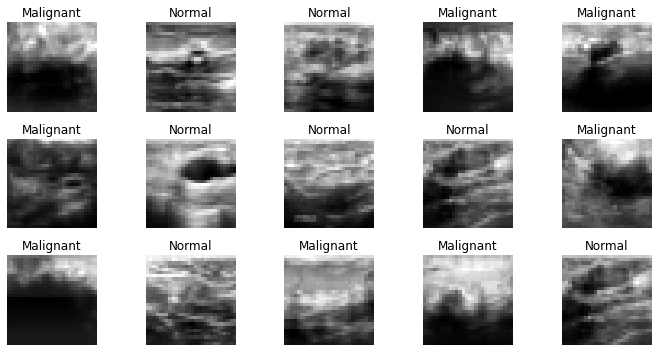

In [143]:
# Plot Ground Truth and coresponding images of train data
plot_ground_truth_images(train_X, train_Y)

In [139]:
# Check for balanced classes in train data

isBalanced, nunique_classes = check_train_class_balance(train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

Is train data classes balanced : False
{0: 147, 1: 399}


In [142]:
# Print final value of evaluation
isBalanced, train_X, train_Y, nunique_classes = oversample_train_data_class(train_X, train_Y)
print("Is train data classes balanced : %s" % isBalanced)
print(nunique_classes)

Is train data classes balanced : True
{0: 399, 1: 399}


In [144]:
# callbacks = [EarlyStopping(monitor="val_loss", patience=3),
# ModelCheckpoint(filepath="/content/best_model.h5",
# monitor="val_loss",
# save_best_only=True)]

# Create self defined model for deep learning
model = create_model_backbone()
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 batch_normalization_7 (Batc  (None, 26, 26, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                      

In [ ]:
# Augment Data and us it for training the model
train_data = augment_train_data(train_X,train_Y, batch_size=32)
model = compile_model(model)
train_model(train_data, model, val_X, val_Y)

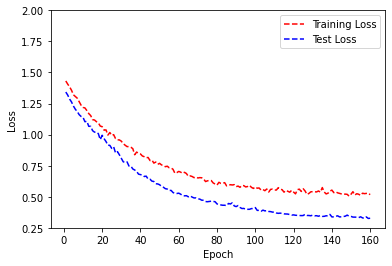

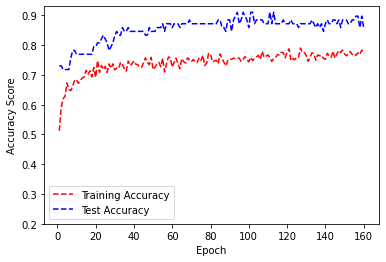

In [104]:
plot_model_accuracy_graph()

In [107]:
ind = 20
predict_class_of_image(model, ind)

1/1 [==============================] - 0s 19ms/step
[[0.3033274]]
[0]


#### Save trained model to file

In [108]:
!mkdir -p saved_model
model.save('saved_model/breast_self_model')

In [110]:
!zip -r /content/saved_model /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/breast_self_model/ (stored 0%)
  adding: content/saved_model/breast_self_model/keras_metadata.pb (deflated 92%)
  adding: content/saved_model/breast_self_model/saved_model.pb (deflated 89%)
  adding: content/saved_model/breast_self_model/variables/ (stored 0%)
  adding: content/saved_model/breast_self_model/variables/variables.data-00000-of-00001 (deflated 47%)
  adding: content/saved_model/breast_self_model/variables/variables.index (deflated 65%)
  adding: content/saved_model/breast_self_model/assets/ (stored 0%)
  adding: content/saved_model/breast_self_model/fingerprint.pb (stored 0%)


In [111]:
from google.colab import files
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>